# Sentiment Analysis

* Sentiment per Season
* Sentiment per Episode
* Sentiment throughout the episode
* Relation between Episode's Sentiment and IMDB rank

In [1]:
import pandas as pd
import numpy as np
import nltk
import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Get the Data
* The transcripts of the first 3 seasons
* The labMT

The labMT 1.0.txt file containing the happiness rating for 10,222 words was obtained from [Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0026752). In short it was constructed as follows:

For the word list, they consulted three sources. Twitter, English-language Google Books, 1960-2007 music lyrics, and the New York Times (1987-2007). They created word lists for each corpus that were arranged according to decreasing frequency of occurrence, then combined the top 5,000 words from each source to create a composite collection of 10,222 unique words.


They obtained 50 independent evaluations for each word by asking Mechanical Turk users to judge how a word made them feel on a nine-point integer scale. They divided the larger assignment into 100 smaller jobs, each requiring the evaluation of roughly 100 randomly chosen words. They highlighted the numbers 1, 3, 5, 7, and 9 using stylised expressions that ranged from unhappy to pleased.

In the paper they also describe that after some experimentation on which values should be considered neutral they discarded the words that had evaluation from 4 to 6. 

For our case we discarded the words that had evaluation from 4 to 6. This, because the wiki pages have generally a neutral tone. Therefore, when we tried to discard all the words with evaluation from 4 to 6 about 200 characters out of the 2200 were found to have no word in their wiki-page that is in the labMT wordlist. 

In [2]:
# directory = "../Data/Transcripts"
# def extract_episode_season_title(file_name):
#     file_name = file_name.replace(".txt", "")
#     parts = file_name.split("_")
#     # season, episode no, title
#     return int(parts[0]),int(parts[1]),parts[2] 

# seasons = []
# episodes = []
# titles = []
# transcripts = []
# for filename in os.listdir(directory):
#     season, episode, title = extract_episode_season_title(filename)
#     seasons.append(season)
#     episodes.append(episode)
#     titles.append(title)
#     #print(f"{season} {episode} {title}")
#     f = os.path.join(directory, filename)
#     if os.path.isfile(f):
#         f = open(f,'r')
#         transcript = f.read()
#         transcripts.append(transcript)
        
# transcripts_df = pd.DataFrame({'season': seasons, 'episode_num': episodes,
#                               'episode_name': titles, 'transcript': transcripts})
# transcripts_df.sort_values(['season', 'episode_num'], ascending=[True, True], inplace = True)
# transcripts_df = transcripts_df.reset_index().drop('index', axis = 1)
# transcripts_df.head()

transcripts_df = pd.read_csv("../Data/transcripts.csv")

In [3]:
labmit1 = pd.read_table("../Data/labMIT-1.0.txt")

#create a dictionary with key the word and value the happinesss average
labmit1_dictionary = dict(zip(labmit1["word"], labmit1["happiness_average"]))

#remove words with sentiment from 4 to 6 
labmit1_dictionary = {word: sentiment for word, sentiment 
                                in labmit1_dictionary.items() 
                                if sentiment <= 4 or sentiment >= 6}

def calculate_sentiment(tokens_list):
    freq = nltk.FreqDist(w for w in tokens_list if w in labmit1_dictionary.keys())
    freq_count = sum(list(freq.values())) 
    sentiment_count = sum(labmit1_dictionary[w]*freq[w] for w in freq.keys())
    if(freq_count != 0):
        return sentiment_count/freq_count
    else:
        return -1
    
def tokenize_and_lemmatize(x):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    lemmatizer = nltk.WordNetLemmatizer()
    
    tokens = tokenizer.tokenize(x)
    lemmatized_tokens = [ lemmatizer.lemmatize(token) for token in tokens]
    return lemmatized_tokens

## Sentiment per episode

In this section we are going to compute the sentiment score of each episode using its transcript and watch how it fluctuates during each season as well as check if there is a sopecific pattern.

### Data preprocessing

* Turn the trasncript text to lowercase
* Tokenize (removing also the punctuation) and lemmatize the transcripts

In [4]:
transcripts_df['transcript'] = transcripts_df['transcript'].str.lower()
transcripts_df['transcript'] = transcripts_df['transcript'].apply(tokenize_and_lemmatize)

,Unnamed: 0,season,episode_num,episode_name,transcript
0,0,1,1,Pilot,"[morty, you, got, to, come, on, you, got, to, ..."
1,1,1,2,Lawnmowner Dog,"[coin, collecting, is, considered, the, perfec..."
2,2,1,3,Anatomy Park,"[mmm, jerry, you, are, really, giving, it, to,..."
3,3,1,4,M. Night Shaym-Aliens!,"[rick, t, t, t, this, is, just, sloppy, crafts..."
4,4,1,5,Meeseeks and Destroy,"[run, morty, do, it, hit, the, button, now, i,..."


### Calculate sentiment score for each episode based on labMT dictionary


In [5]:
transcripts_df['sentiment_score'] = transcripts_df['transcript'].apply(calculate_sentiment)

,Unnamed: 0,season,episode_num,episode_name,transcript,sentiment_score
0,0,1,1,Pilot,"[morty, you, got, to, come, on, you, got, to, ...",6.001736
1,1,1,2,Lawnmowner Dog,"[coin, collecting, is, considered, the, perfec...",5.865759
2,2,1,3,Anatomy Park,"[mmm, jerry, you, are, really, giving, it, to,...",6.006583
3,3,1,4,M. Night Shaym-Aliens!,"[rick, t, t, t, this, is, just, sloppy, crafts...",6.079223
4,4,1,5,Meeseeks and Destroy,"[run, morty, do, it, hit, the, button, now, i,...",5.992902


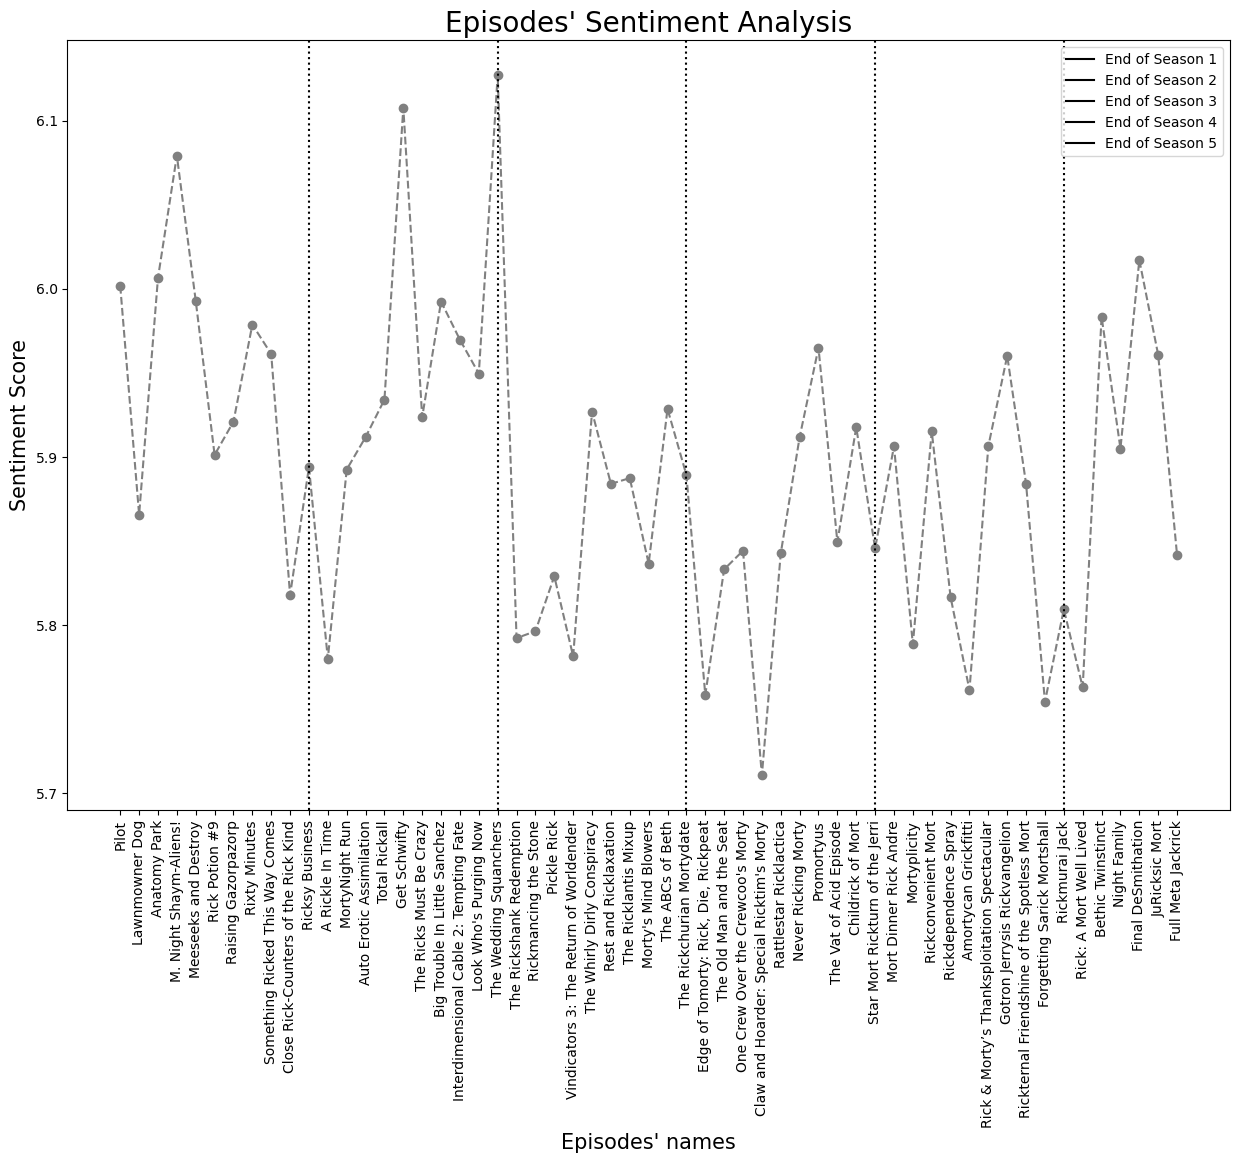

In [6]:
# plot 
fig, ax = plt.subplots(figsize = (15,10))
#plt.bar(transcripts_df['episode_name'], transcripts_df['sentiment_score'])

#plt.step(transcripts_df['episode_name'], transcripts_df['sentiment_score'], label='pre (default)')
plt.plot(transcripts_df['episode_name'], transcripts_df['sentiment_score'], 'o--', color='grey')
legends = [Line2D([0], [0], marker=None, color="k", label= "End of Season 1"),
          Line2D([0], [0], marker=None, color="k", label= "End of Season 2"),
          Line2D([0], [0], marker=None, color="k", label= "End of Season 3"),
          Line2D([0], [0], marker=None, color="k", label= "End of Season 4"),
          Line2D([0], [0], marker=None, color="k", label= "End of Season 5")]

ax.axvline('Ricksy Business', color="k", linestyle = ":")
ax.axvline('The Wedding Squanchers', color="k", linestyle = ":")
ax.axvline('The Rickchurian Mortydate', color="k", linestyle = ":")
ax.axvline('Star Mort Rickturn of the Jerri', color="k", linestyle = ":")
ax.axvline('Rickmurai Jack', color="k", linestyle = ":")
ax.set_xlabel("Episodes' names", size = 15)
ax.set_ylabel("Sentiment Score", size = 15)
plt.xticks(rotation=90)
plt.legend(handles = legends, loc=1, fontsize = 10)
plt.title("Episodes' Sentiment Analysis", size=20)
#plt.legend(handles = legends, loc=1, fontsize = 10)
plt.show()





# plt.figure(figsize=(30, 18))
# plt.plot(transcripts_df['episode_name'], transcripts_df['sentiment_score'])
# plt.xticks(rotation=90)
# plt.title("Episode Sentiment Analysis")
# plt.xlabel("Episodes")
# plt.ylabel("Sentiment Score")
# plt.show()
# last episode: 1. 11, 2. 10, 3. 10, 4. 10, 5. 10, 6. 7

In the plot above we can see that sentiment fluctuates during every season without beiing able to extract a specific pattern.

## Sentiment throughout the episode

In this section we are going to split the transcript in three same sized parts to see if there is a psecific pattern in the sentiment fluctuation during eahch episode.

In [7]:
transcripts_df2 = pd.read_csv("../Data/transcripts.csv")
transcripts_df2['transcript'] = transcripts_df2['transcript'].str.lower()
transcripts_df2['transcript'] = transcripts_df2['transcript'].apply(tokenize_and_lemmatize)

def split_into_3(transcript, part):
    length = len(transcript)
    if part == 1:
        first_part = transcript[:int(length/3)]
        return first_part
    elif part == 2:
        second_part = transcript[int(length/3):int(2*length/3)]
        return second_part
    elif part ==3:
        third_part = transcript[int(2*length/3):length]
        return third_part
    else:
        return []

transcripts_df2['first_part'] = transcripts_df2['transcript'].apply(lambda x: split_into_3(x,1))
transcripts_df2['second_part'] = transcripts_df2['transcript'].apply(lambda x: split_into_3(x,2))
transcripts_df2['third_part'] = transcripts_df2['transcript'].apply(lambda x: split_into_3(x,3))

In [8]:
transcripts_df2['first_part_sentiment_score'] = transcripts_df2['first_part'].apply(calculate_sentiment)
transcripts_df2['second_part_sentiment_score'] = transcripts_df2['second_part'].apply(calculate_sentiment)
transcripts_df2['third_part_sentiment_score'] = transcripts_df2['third_part'].apply(calculate_sentiment)

In [9]:
transcripts_df2.head()

,Unnamed: 0,season,episode_num,episode_name,transcript,first_part,second_part,third_part,first_part_sentiment_score,second_part_sentiment_score,third_part_sentiment_score
0,0,1,1,Pilot,"[morty, you, got, to, come, on, you, got, to, ...","[morty, you, got, to, come, on, you, got, to, ...","[that, fight, i, sense, that, you, re, busy, a...","[the, last, two, month, what, why, didn, t, yo...",5.992779,6.026596,5.987247
1,1,1,2,Lawnmowner Dog,"[coin, collecting, is, considered, the, perfec...","[coin, collecting, is, considered, the, perfec...","[whoa, whoa, whoa, what, s, the, matter, with,...","[perfectly, scary, enough, a, it, is, hey, yo,...",6.100261,5.681877,5.828735
2,2,1,3,Anatomy Park,"[mmm, jerry, you, are, really, giving, it, to,...","[mmm, jerry, you, are, really, giving, it, to,...","[follow, u, into, the, respiratory, system, th...","[you, anything, man, you, are, who, you, are, ...",6.135268,5.846466,6.012617
3,3,1,4,M. Night Shaym-Aliens!,"[rick, t, t, t, this, is, just, sloppy, crafts...","[rick, t, t, t, this, is, just, sloppy, crafts...","[this, w, what, do, they, want, rick, well, th...","[i, m, not, saying, it, should, win, an, award...",5.998613,6.086863,6.147774
4,4,1,5,Meeseeks and Destroy,"[run, morty, do, it, hit, the, button, now, i,...","[run, morty, do, it, hit, the, button, now, i,...","[jar, fee, fi, fo, fum, just, give, up, morty,...","[to, follow, you, into, some, nonsensical, bul...",6.185000,5.864125,5.940570


In [10]:
print(transcripts_df2['first_part_sentiment_score'].mean())
print(transcripts_df2['second_part_sentiment_score'].mean())
print(transcripts_df2['third_part_sentiment_score'].mean())

5.944929790760665
5.871882598947657
5.86998257965504


From the mean values we have an indication that the first part of the plot tends to be have a bigger sentiment score compared to the other two parts whereas the other two are very close to each other.

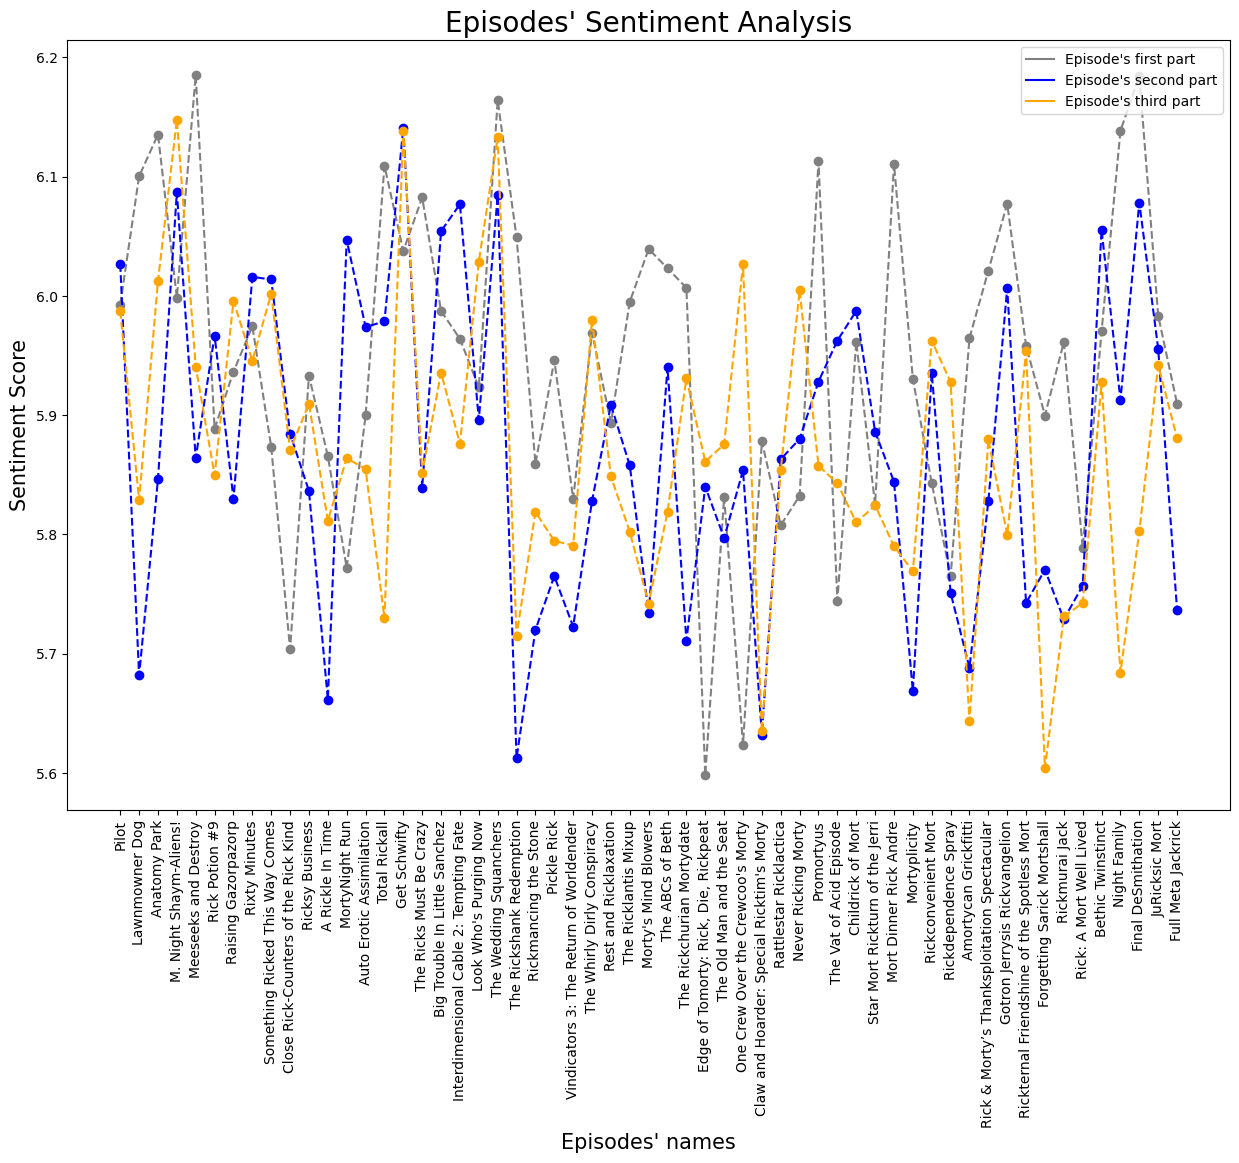

In [26]:
# plot 
fig, ax = plt.subplots(figsize = (15,10))
plt.plot(transcripts_df2['episode_name'], transcripts_df2['first_part_sentiment_score'],
         'o--', color='grey',label='first part')
plt.plot(transcripts_df2['episode_name'], transcripts_df2['second_part_sentiment_score'],
         'o--', color='blue',label='second part')
plt.plot(transcripts_df2['episode_name'], transcripts_df2['third_part_sentiment_score'],
         'o--', color='orange',label='third part')
legends = [Line2D([0], [0], marker=None, color="grey", label= "Episode's first part"),
          Line2D([0], [0], marker=None, color="blue", label= "Episode's second part"),
          Line2D([0], [0], marker=None, color="orange", label= "Episode's third part")]

# ax.axvline('Ricksy Business', color="k", linestyle = ":")
# ax.axvline('The Wedding Squanchers', color="k", linestyle = ":")
# ax.axvline('The Rickchurian Mortydate', color="k", linestyle = ":")
# ax.axvline('Star Mort Rickturn of the Jerri', color="k", linestyle = ":")
# ax.axvline('Rickmurai Jack', color="k", linestyle = ":")
ax.set_xlabel("Episodes' names", size = 15)
ax.set_ylabel("Sentiment Score", size = 15)
plt.xticks(rotation=90)
plt.legend(handles = legends, loc=1, fontsize = 10)
plt.title("Episodes' Sentiment Analysis", size=20)
#plt.legend(handles = legends, loc=1, fontsize = 10)
plt.show()


## Relation between sentiment and imdb rating

In this section we are going to use the ratings that we scrapped from imdb for each episode in order to check if there is a correlation between the sentiment score and the imdb rating.

In [12]:
ratings_df = pd.read_csv("../Data/ratings.csv")
ratings_df['lower_name'] = ratings_df['movie_title'].str.lower()
transcripts_df['lower_name'] = transcripts_df['episode_name'].str.lower()

In [13]:
merged = transcripts_df.merge(ratings_df[['lower_name','movie_title', 'rating']], left_on = 'lower_name', right_on='lower_name', how='inner')
merged = merged.drop(['movie_title', 'lower_name'], axis=1)
merged = merged[merged['rating']>0]

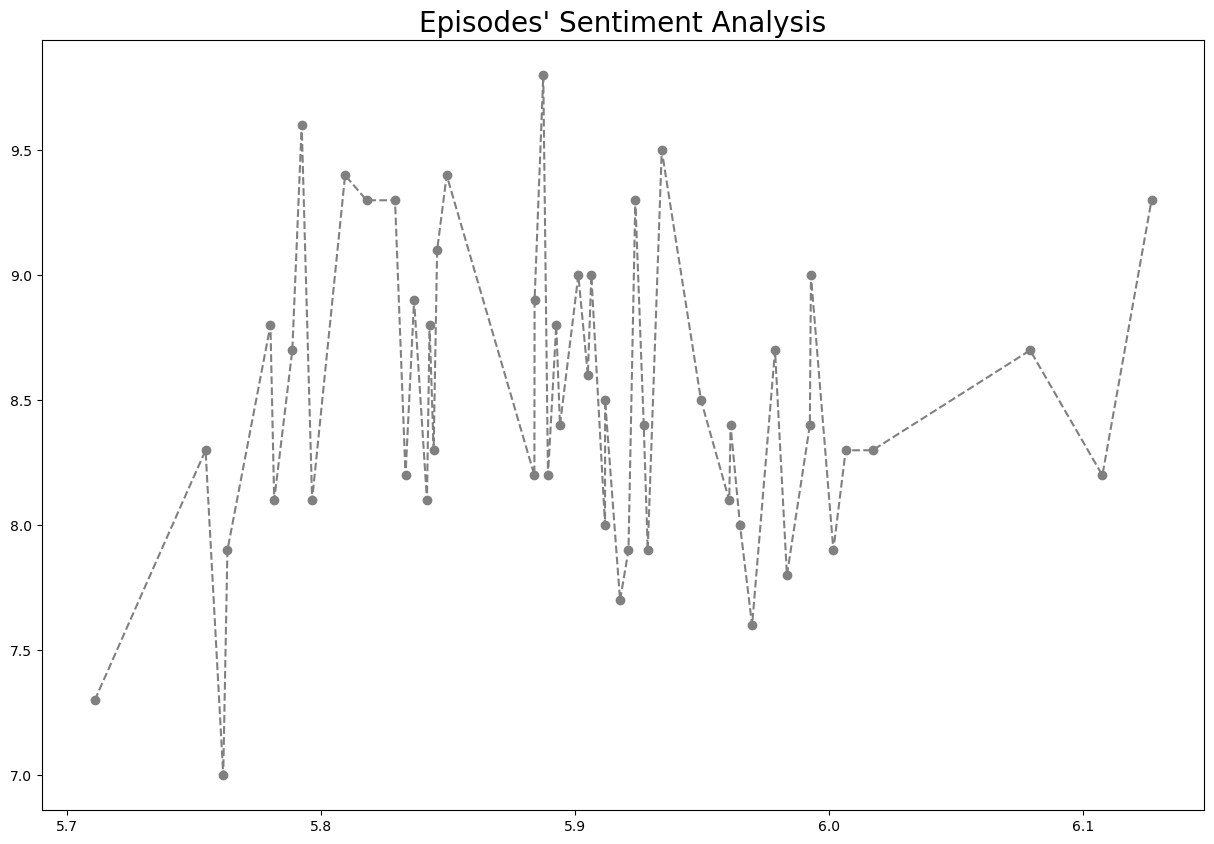

 corr = 0.03431754455582813


In [14]:
 # plot 
merged.sort_values('sentiment_score', ascending=True, inplace=True)
fig, ax = plt.subplots(figsize = (15,10))
plt.plot(merged['sentiment_score'], merged['rating'],
         'o--', color='grey',label='first part')
#plt.legend(handles = legends, loc=1, fontsize = 10)
plt.title("Episodes' Sentiment Analysis", size=20)
#plt.legend(handles = legends, loc=1, fontsize = 10)
plt.show()

print(f" corr = {merged['rating'].corr(merged['sentiment_score'], method='pearson')}")

From the plot above betwwen the sentiment score and the imdb rating we cannot see any correlation. 
Furthermore we computed the perason correlation coefficient between these two varaibles and from the result our intuition seems to be proved.

# Sentiment Analysis Using NRC

LabMT word list as described above was created to analyze tweets. A series (or movie) plot is a piece of text a lot different than a tweet. Therefore we wanted to use a more robust tool to do our sentiment analysis. Therefore we picked the NRC sentiment analysis library.

In [15]:
from nrclex import NRCLex

def calculate_nrc_sentiment(tokens_list):
    #print(NRCLex(tokens_list).raw_emotion_scores)
    return NRCLex(tokens_list).raw_emotion_scores

def clean_and_lemmatize(x):
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    lemmatizer = nltk.WordNetLemmatizer()
    
    tokens = tokenizer.tokenize(x)
    lemmatized_tokens = [ lemmatizer.lemmatize(token) for token in tokens]
    lemmatized_tokens = " ".join(lemmatized_tokens)
    return lemmatized_tokens



In [16]:
transcripts_df = pd.read_csv("../Data/transcripts.csv")
transcripts_df['transcript'] = transcripts_df['transcript'].str.lower()
transcripts_df['transcript'] = transcripts_df['transcript'].apply(clean_and_lemmatize)
transcripts_df.head()

,Unnamed: 0,season,episode_num,episode_name,transcript
0,0,1,1,Pilot,morty you got to come on you got to come with ...
1,1,1,2,Lawnmowner Dog,coin collecting is considered the perfect hobb...
2,2,1,3,Anatomy Park,mmm jerry you are really giving it to this ham...
3,3,1,4,M. Night Shaym-Aliens!,rick t t t this is just sloppy craftsmanship m...
4,4,1,5,Meeseeks and Destroy,run morty do it hit the button now i can t do ...


In [18]:
nrc_sents_scores = transcripts_df['transcript'].apply(calculate_nrc_sentiment)

nrc_sents_dict = {'joy':[],'trust':[],'anticipation':[],'fear':[],'anger':[],'disgust':[],
             'sadness':[],'surprise':[],'positive':[],'negative':[]}

for sent,associated_list in nrc_sents_dict.items():
    for score in nrc_sents_scores:
        associated_list.append(score[sent])
    transcripts_df[sent] = associated_list


transcripts_df.head()

,Unnamed: 0,season,episode_num,episode_name,transcript,joy,trust,anticipation,fear,anger,disgust,sadness,surprise,positive,negative
0,0,1,1,Pilot,morty you got to come on you got to come with ...,85,137,77,76,66,52,66,46,182,128
1,1,1,2,Lawnmowner Dog,coin collecting is considered the perfect hobb...,56,103,72,89,56,65,60,29,148,126
2,2,1,3,Anatomy Park,mmm jerry you are really giving it to this ham...,81,94,86,74,53,48,59,27,150,114
3,3,1,4,M. Night Shaym-Aliens!,rick t t t this is just sloppy craftsmanship m...,86,127,95,47,23,34,38,63,160,92
4,4,1,5,Meeseeks and Destroy,run morty do it hit the button now i can t do ...,78,110,106,83,59,42,70,37,175,138


## Sentiment throughout the episode

In [28]:
transcripts_df['first_part'] = transcripts_df['transcript'].apply(lambda x: split_into_3(x,1))
transcripts_df['second_part'] = transcripts_df['transcript'].apply(lambda x: split_into_3(x,2))
transcripts_df['third_part'] = transcripts_df['transcript'].apply(lambda x: split_into_3(x,3))

In [32]:
parts = ['first_part', 'second_part', 'third_part']

for part in parts:
    nrc_sents_scores = transcripts_df[part].apply(calculate_nrc_sentiment)

    nrc_sents_dict = {'joy':[],'trust':[],'anticipation':[],'fear':[],'anger':[],'disgust':[],
                 'sadness':[],'surprise':[],'positive':[],'negative':[]}

    for sent,associated_list in nrc_sents_dict.items():
        for score in nrc_sents_scores:
            associated_list.append(score[sent])
        transcripts_df[part+'_'+sent] = associated_list

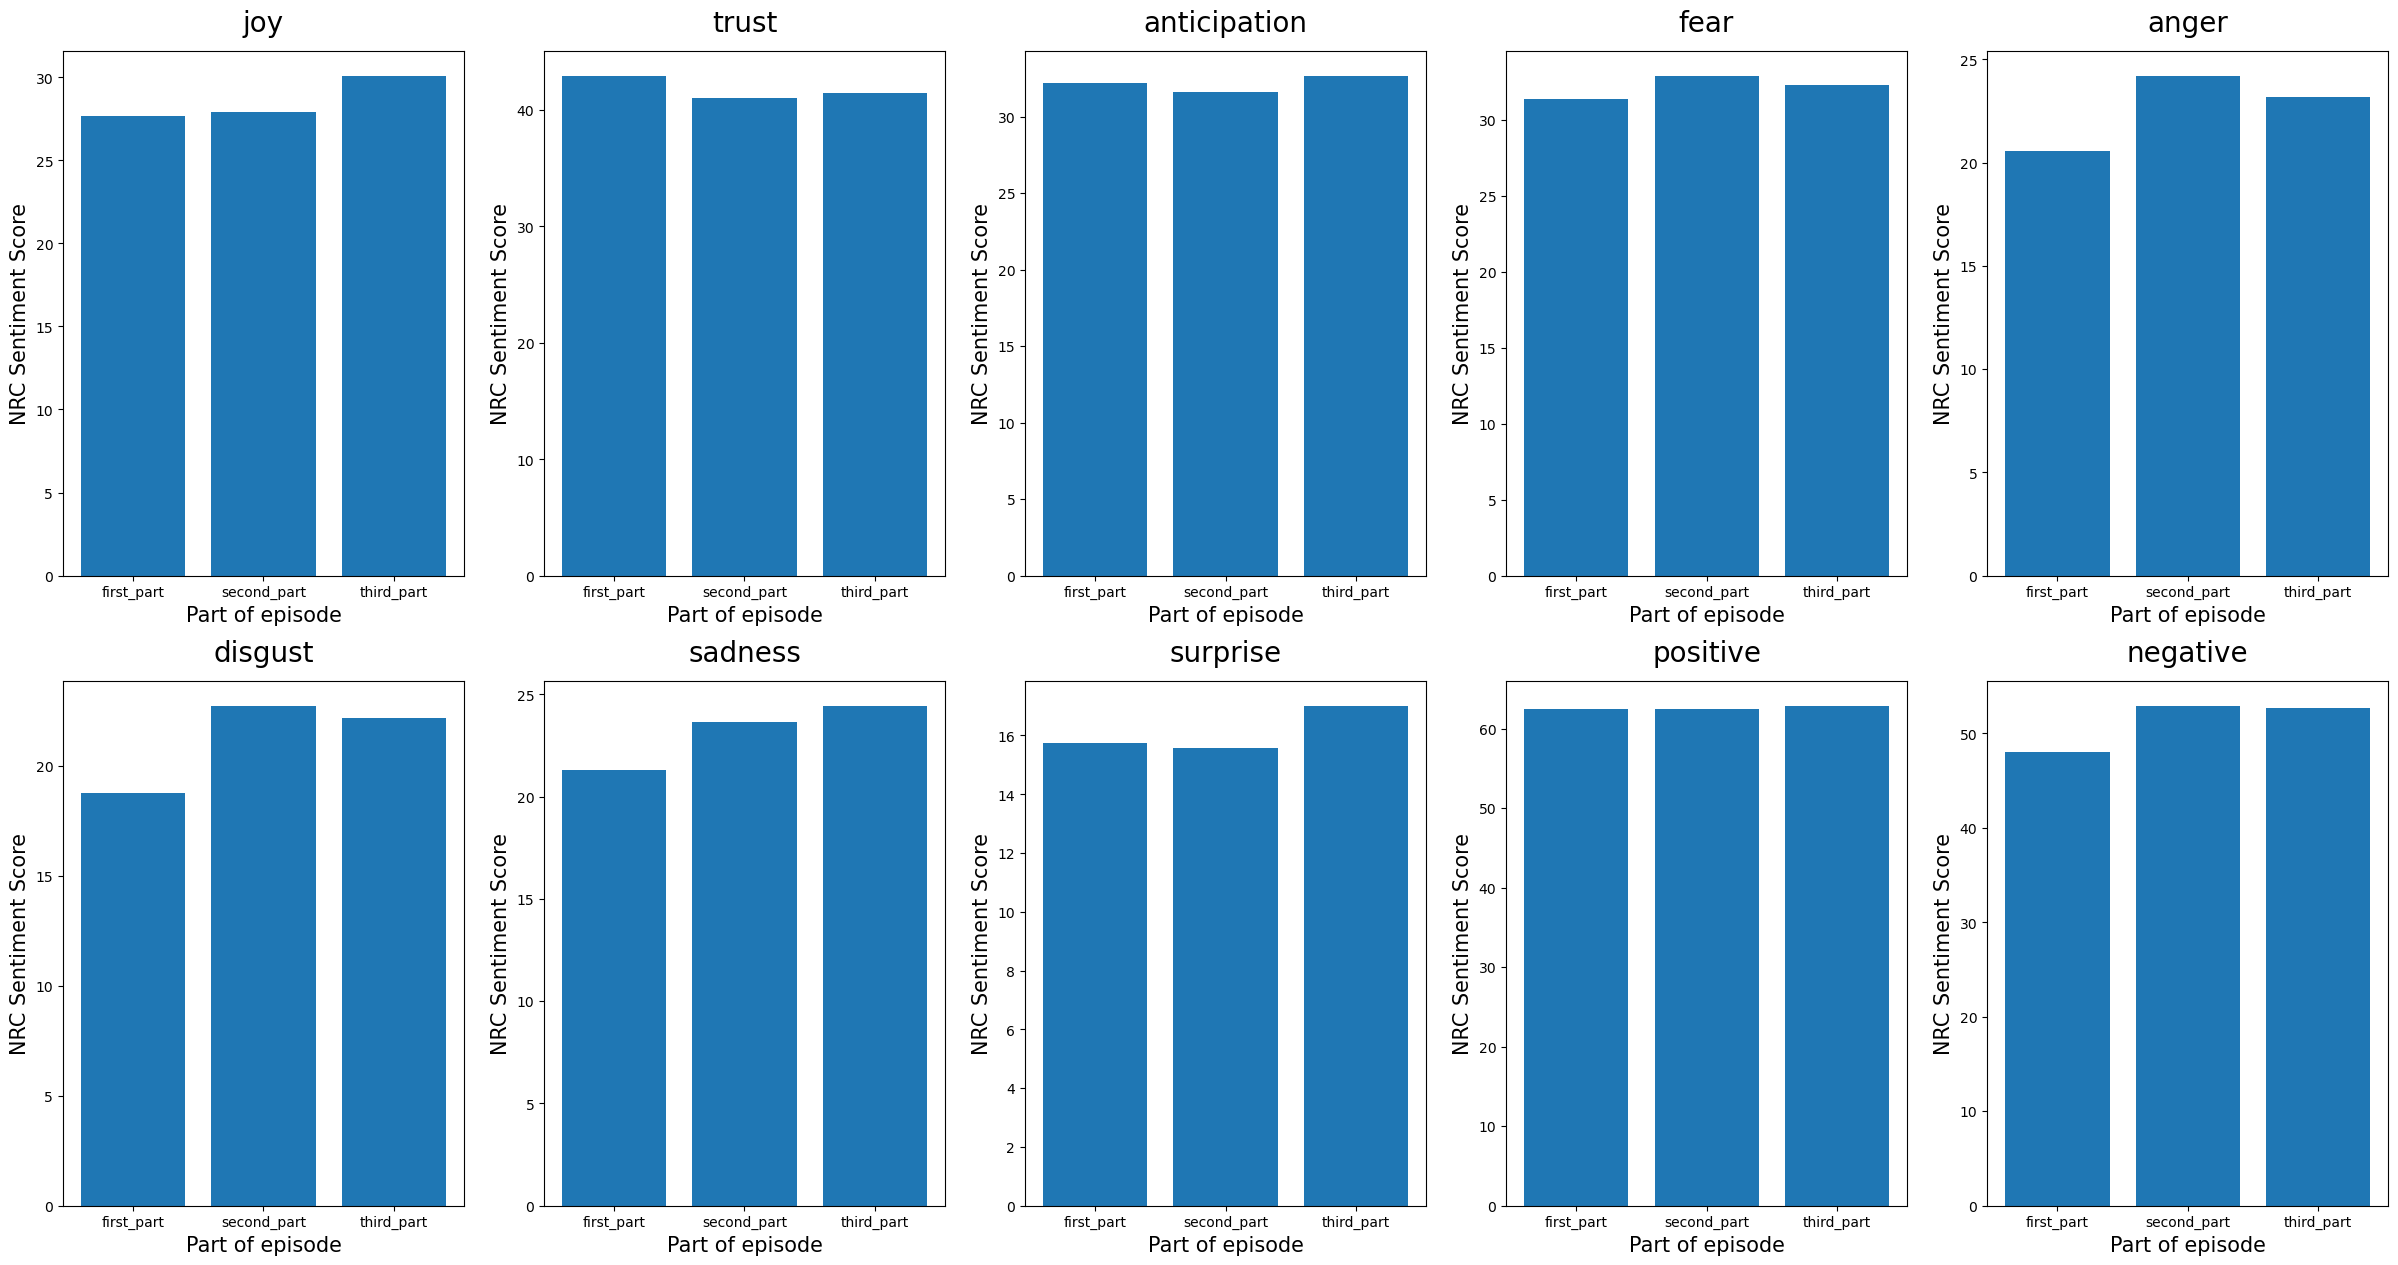

In [49]:
# sent_per_part = [[],[],[]]
# for sent in nrc_sents_dict.keys():
#     for part in parts:
#         print(f"{part+'_'+sent} mean = {transcripts_df[part+'_'+sent].mean()}")
        
fig, axs = plt.subplots(nrows=2, ncols = 5, figsize = (30, 15))
s=0
for i in range(2):
    for j in range(5):
        sent = list(nrc_sents_dict.keys())[s]
        scores = [transcripts_df[part+'_'+sent].mean() for part in parts]
        
        axs[i, j].bar(parts,scores)
        axs[i, j].set_title(sent, fontsize = 20, pad=14)
        axs[i, j].set_xlabel("Part of episode", size = 15)
        axs[i, j].set_ylabel("NRC Sentiment Score", size = 15)
        s+=1
plt.show()

Here we analyzed again h

## Relation between sentiment and imdb rating

In [19]:
ratings_df = pd.read_csv("../Data/ratings.csv")
ratings_df['lower_name'] = ratings_df['movie_title'].str.lower()
transcripts_df['lower_name'] = transcripts_df['episode_name'].str.lower()

merged = transcripts_df.merge(ratings_df[['lower_name','movie_title', 'rating']], left_on = 'lower_name', right_on='lower_name', how='inner')
merged = merged.drop(['movie_title', 'lower_name'], axis=1)
merged = merged[merged['rating']>0]

In [21]:
correlations = []
for sent in nrc_sents_dict.keys():
#     # plot 
#     merged.sort_values(sent, ascending=True, inplace=True)
#     fig, ax = plt.subplots(figsize = (15,10))
#     plt.plot(merged[sent], merged['rating'],
#              'o--', color='grey',label='first part')
#     #plt.legend(handles = legends, loc=1, fontsize = 10)
#     plt.title("Episodes' Sentiment Analysis", size=20)
#     #plt.legend(handles = legends, loc=1, fontsize = 10)
#     plt.show()
    correlations.append(merged['rating'].corr(merged[sent], method='pearson'))
    print(f"{sent} corr = {merged['rating'].corr(merged[sent], method='pearson')}")

joy corr = -0.07523347312599472
trust corr = -0.018898693282560986
anticipation corr = -0.046773531366067184
fear corr = -0.051711440673278736
anger corr = -0.18235867775979742
disgust corr = -0.16674113837740356
sadness corr = -0.13590303053601346
surprise corr = 0.13803345037848302
positive corr = -0.07574202479738068
negative corr = -0.004904496614212924


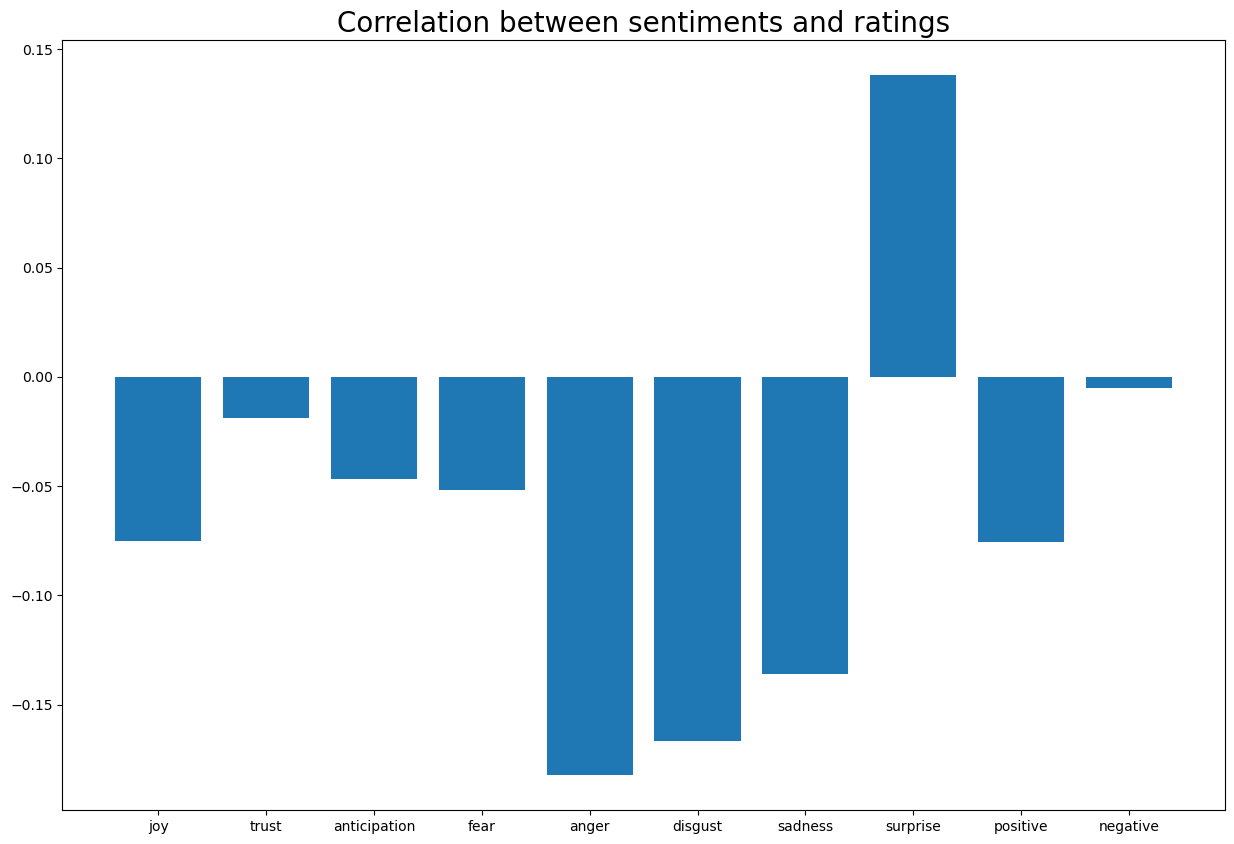

In [23]:
# plot 

fig, ax = plt.subplots(figsize = (15,10))
plt.bar(nrc_sents_dict.keys(), correlations)
#plt.legend(handles = legends, loc=1, fontsize = 10)
plt.title("Correlation between sentiments and ratings", size=20)
#plt.legend(handles = legends, loc=1, fontsize = 10)
plt.show()

Our first observation here is that none of the sentiments from NRC list has a very strong correlation to the imdb ratings. Nevertheless, it is clear that sentiments such as anger, disgust, and sadness have a negative correlation with the imdb ratings. Another insteresting finding is that the only sentiment that has positive correlation with the imdb rating is the surprise sentiment.